In [0]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage.transform import resize
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from google.colab import files

In [0]:
URL_ENDPOINT = "http://cs.mcgill.ca/~ksinha4/datasets/kaggle/"

train_x = np.loadtxt(URL_ENDPOINT+"train_x.csv", delimiter=",")
train_y = np.loadtxt(URL_ENDPOINT+"train_y.csv", delimiter=",")
# test_x = np.loadtxt(URL_ENDPOINT+"test_x.csv", delimiter=",")

In [0]:
x = train_x.reshape(-1, 64, 64) # reshape 
y = train_y.reshape(-1, 1) 
# test = test_x.reshape(-1, 64, 64)

In [0]:
def find_largest_bounding_box(im):
  # convert to binary image
#   _, im = cv2.threshold(im,254,255,cv2.THRESH_BINARY)
  im[im<255]=0
  im[im==255]=1
  
  label_im, nb_labels = ndimage.label(im)
  
  # find largest connected component
  sizes = ndimage.sum(im, label_im, range(nb_labels + 1))
  mask_size = sizes < 4**2
  remove_pixel = mask_size[label_im]
  label_im[remove_pixel] = 0
  labels = np.unique(label_im)
  label_im = np.searchsorted(labels, label_im)

  digits = ndimage.find_objects(label_im)
  max_side = 0
  max_ind = 0
  for i in range(0,len(digits)):
    bound = im[digits[i]]
    if np.max(bound.shape) > max_side:
      max_side = np.max(bound.shape)
      max_ind = i

  bound_rec = im[digits[max_ind]]
  
  # pad and resize
#   if bound_rec.shape[0] > bound_rec.shape[1]:
#     resize_short = round(24*bound_rec.shape[1]/bound_rec.shape[0])
#     bound_rec = resize(bound_rec, (24, resize_short), mode='reflect')
#     pad_before = (np.ceil((28 - resize_short)/2)).astype(int)
#     pad_after = (np.floor((28 - resize_short)/2)).astype(int)
#     bound_squ = np.pad(bound_rec,((2,2),(pad_before, pad_after)),'constant', constant_values=0)
    
#   else:
#     resize_short = round(24*bound_rec.shape[0]/bound_rec.shape[1])
#     bound_rec = resize(bound_rec, (resize_short, 24), mode='reflect')
#     pad_before = (np.ceil((28 - resize_short)/2)).astype(int)
#     pad_after = (np.floor((28 - resize_short)/2)).astype(int)
#     bound_squ = np.pad(bound_rec,((pad_before, pad_after),(2,2)),'constant', constant_values=0)
#   _, bound_squ = cv2.threshold(bound_squ,254,255,cv2.THRESH_BINARY)

  # pad and resize
  if bound_rec.shape[0] > bound_rec.shape[1]:
    resize_short = round(28*bound_rec.shape[1]/bound_rec.shape[0])
    bound_rec = resize(bound_rec, (28, resize_short), mode='reflect')
    pad_before = (np.ceil((28 - resize_short)/2)).astype(int)
    pad_after = (np.floor((28 - resize_short)/2)).astype(int)
    bound_squ = np.pad(bound_rec,((0,0),(pad_before, pad_after)),'constant', constant_values=0)
    
  else:
    resize_short = round(28*bound_rec.shape[0]/bound_rec.shape[1])
    bound_rec = resize(bound_rec, (resize_short, 28), mode='reflect')
    pad_before = (np.ceil((28 - resize_short)/2)).astype(int)
    pad_after = (np.floor((28 - resize_short)/2)).astype(int)
    bound_squ = np.pad(bound_rec,((pad_before, pad_after),(0,0)),'constant', constant_values=0)



  bound_squ[bound_squ<1] = 0
  
  return bound_squ

In [0]:
def preprocess(train):
  prep = np.zeros((len(train),28,28))
  for i in range(0,len(prep)):
    prep[i] = find_largest_bounding_box(train[i].copy())
  return prep

In [42]:
prep_x = preprocess(x)
# np.savetxt('prep_train_x.csv',prep_x.reshape(-1,28**2),delimiter=',')
# prep_test = preprocess(test)
# np.savetxt('prep_test_x.csv',prep_test.reshape(-1,28**2),delimiter=',')

/usr/local/lib/python3.6/dist-packages/scipy/ndimage/measurements.py:431: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  safe = ((np.issubdtype(dt, int) and dt.itemsize <= int_size) or


y: [5.]


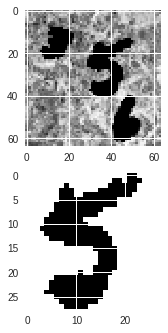

In [43]:
# # examples of preprocessed image

# d = 3650
# print('y:', y[d])
# plt.subplot(211)
# plt.imshow(x[d])
# plt.subplot(212)
# plt.imshow(prep_x[d])

In [0]:
# train = prep_x[:40000]
# train = train.reshape(-1,28**2)
# train_y = y[:40000]
# valid = prep_x[40000:]
# valid = valid.reshape(-1,28**2)
# valid_y = y[40000:]

In [0]:
# linear SVM
def sclf(x,y,c,test):
  clf = LinearSVC(C=c, random_state=0)
  clf.fit(x, y)
  return clf.predict(test)

In [0]:
sec = np.zeros((5,10000,28,28))
sec[0] = prep_x[:10000]
sec[1] = prep_x[10000:20000]
sec[2]= prep_x[20000:30000]
sec[3] = prep_x[30000:40000]
sec[4] = prep_x[40000:]

sec_y = np.zeros((5,10000,1))
sec_y[0] = y[:10000]
sec_y[1] = y[10000:20000]
sec_y[2]= y[20000:30000]
sec_y[3] = y[30000:40000]
sec_y[4] = y[40000:]

In [0]:
# validation
s = np.zeros(10)
param = 0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000
for i in range(0,10):
  for j in range(0,5):
    train = np.concatenate((sec[j%5],sec[(j+1)%5],sec[(j+2)%5],sec[(j+3)%5]))
    train = train.reshape(-1,28**2)
    train_y = np.concatenate((sec_y[j%5],sec_y[(j+1)%5],sec_y[(j+2)%5],sec_y[(j+3)%5]))
    valid = sec[(j+4)%5]
    valid = valid.reshape(-1,28**2)
    valid_y = sec_y[(j+4)%5]
    
    s[i] = s[i] + accuracy_score(valid_y, sclf(train,train_y,param[i],valid))

s = s/5

# estimate validation set with best c
est_valid = sclf(train,train_y,param[np.argmax(s)],valid)
print('Best validation accuracy:', np.max(s))
print('Best param:', param[np.argmax(s)])

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [46]:
# # validation
# s = np.zeros(10)
# param = 0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000
# for i in range(0,10):
#   s[i] = accuracy_score(valid_y, sclf(train,train_y,param[i],valid))

# # estimate validation set with best c
# est_valid = sclf(train,train_y,param[np.argmax(s)],valid)
# print('Best validation accuracy:', np.max(s))
# print('Best param:', param[np.argmax(s)])

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best validation accuracy: 0.7374
Best param: 0.001


y: [8.]
estimated y: 8.0


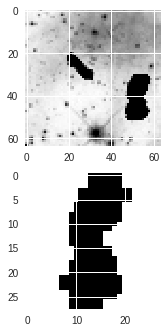

In [47]:
# d = 0
# print('y:', valid_y[d])
# print('estimated y:', est_valid[d])
# plt.subplot(211)
# plt.imshow(x[40000+d])
# plt.subplot(212)
# plt.imshow(prep_x[40000+d])

In [102]:
est_test = sclf(train,train_y,param[np.argmax(s)],prep_test.reshape(-1,28**2))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
result = np.concatenate((np.asarray(range(0,len(est_test))).reshape(len(est_test),1),est_test.reshape(len(est_test),1)), axis=1).astype(int)
np.savetxt('test_y.csv',result,delimiter=',',header='Id,Label')
files.download('test_y.csv')